# Conditional tabular DDPM Exploration

1. Simulate tabular data using the example from Syn
2. Build tabular DDPM from scratch based on: https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1
3. Train and evaluate the generation result
4. Modify reverse process to achieve conditional generation via missing value imputation
5. If it didn't work, try conditioning 



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import QuantileTransformer
from scipy.stats import norm


import pickle
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

from utils_data import TrueSampler
from utils_model import MLPDiffusionContinuous

from ddpm import MyDDPM, generate_samples, generate_imputation

import sys

sys.path.insert(0, "../tab-ddpm/pass-inference/syninf/")
from utils_viz import plot_distribution, compare_distributions_grid, heatmap_correlation
from utils_syninf import catboost_pred_model, test_rmse

seed = 2024

# Inference

Run `python train_script.py` to get model checkpoints and saved pipeline for quantile transformation

In [4]:
# Initialization #

d_in = 8
d_time = 128
hidden_dims = [512, 256, 256, 256, 256, 128]
n_steps = 1000

device = "cuda:7"


noise_pred_network = MLPDiffusionContinuous(
    d_in=d_in, hidden_dims=hidden_dims, dim_t=d_time
)
tabular_ddpm = MyDDPM(network=noise_pred_network, n_steps=n_steps, device=device)


# Loading trained model for inference
tabular_ddpm.load_state_dict(torch.load("./ckpt/tabular_ddpm.pt"))

# Loading quantile transformer pipeline used during training
qt = joblib.load("./ckpt/qt_train.joblib")

# True sample
yx_true_unnorm = np.load("./data/yx.npy")
yx_true_norm = qt.transform(yx_true_unnorm)

## Fidelity of generation

In [165]:
# Generate synthetic samples #

seed = 2024

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


yx_fake = generate_samples(tabular_ddpm, n_samples=5000, tabular_dim=d_in)
yx_fake_norm = yx_fake.cpu().detach().numpy()

# Transform back to original scale
yx_fake_unnorm = qt.inverse_transform(yx_fake_norm)

Imputation at step 989:   0%|          | 0/1000 [00:00<?, ?it/s]

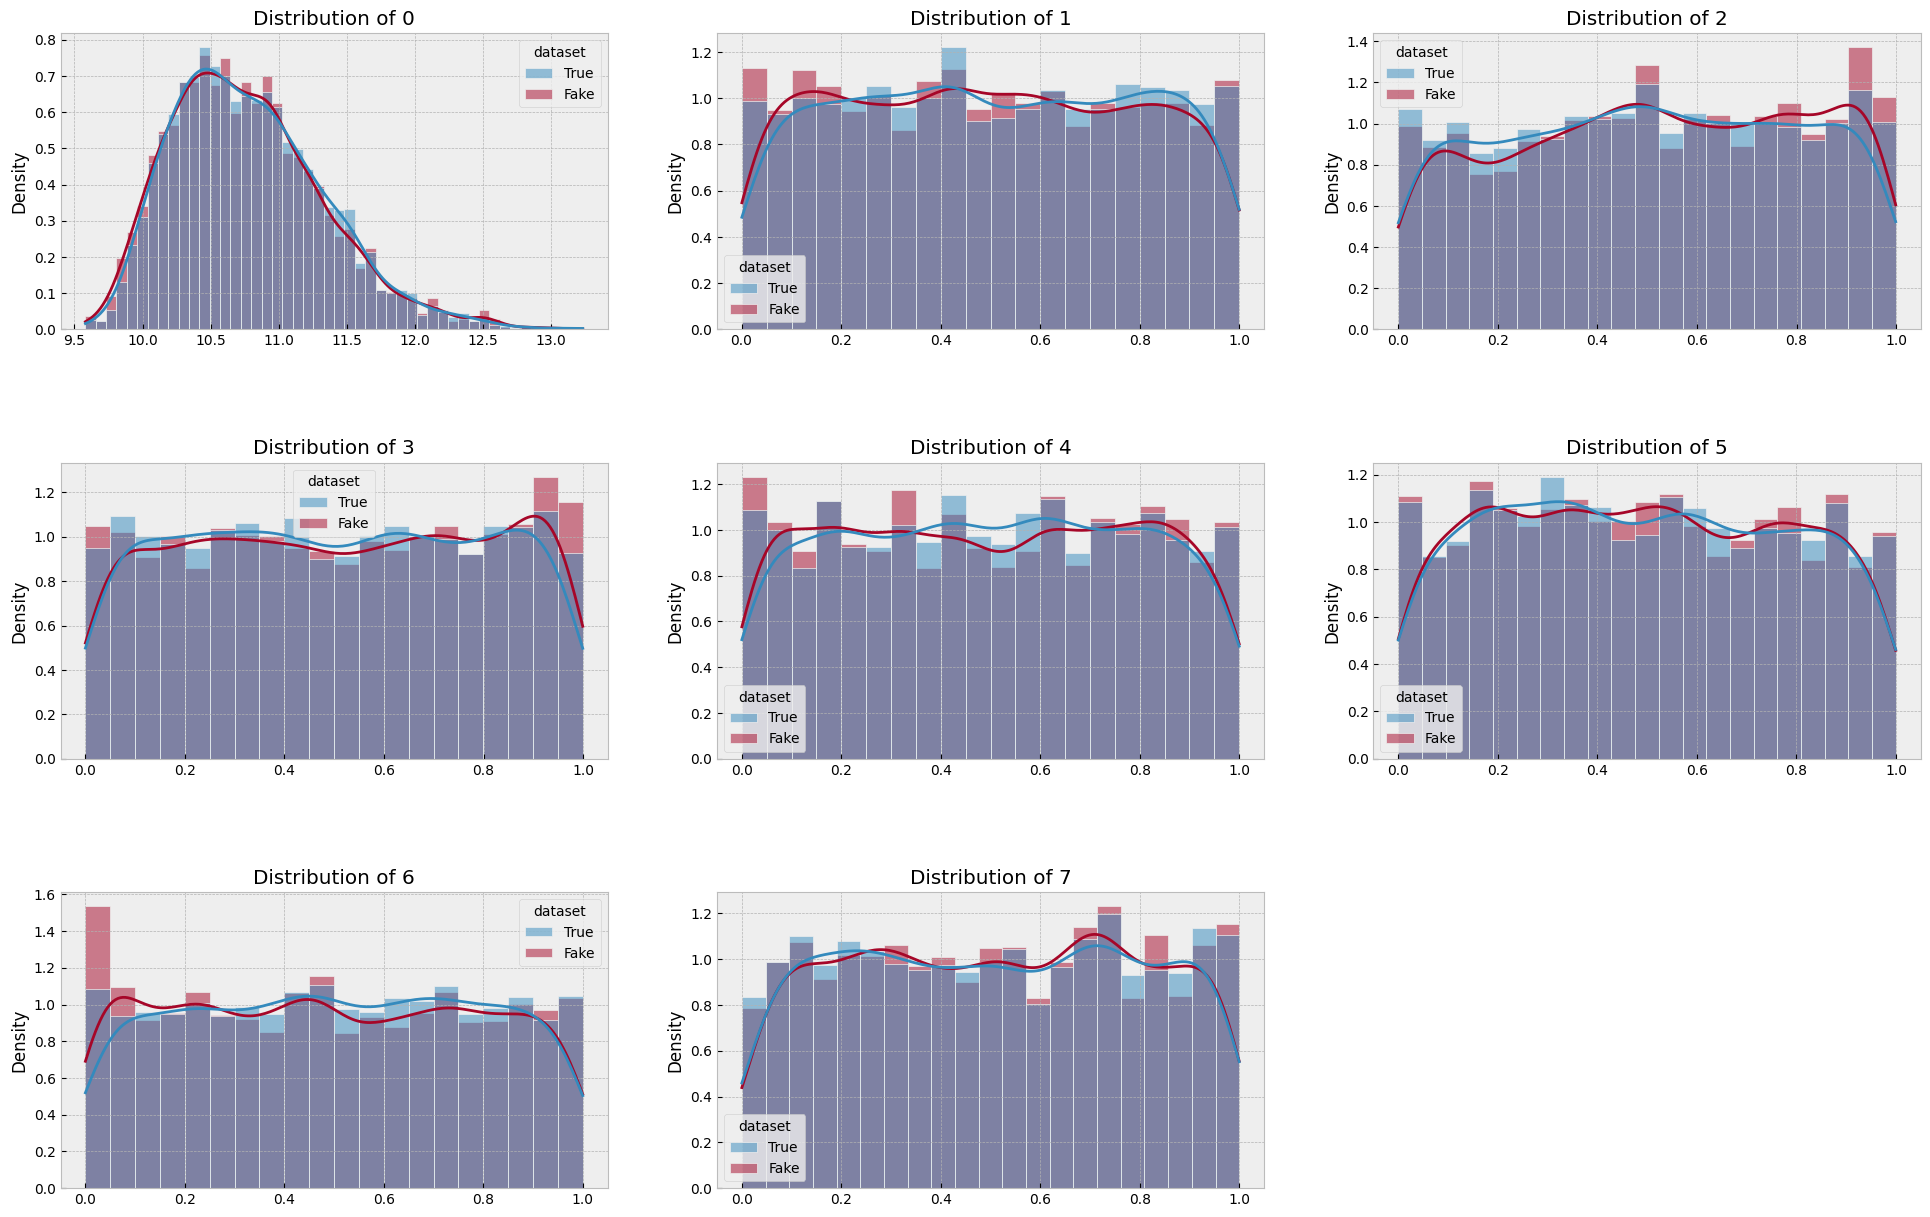

In [166]:
# Evaluate the fidelity of the fake sample #
df_true = pd.DataFrame(yx_true_unnorm)
df_fake = pd.DataFrame(yx_fake_unnorm)
compare_distributions_grid([df_true, df_fake], ["True", "Fake"], nrows=3, ncols=3)

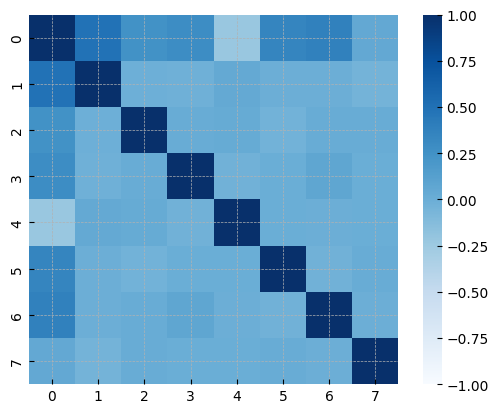

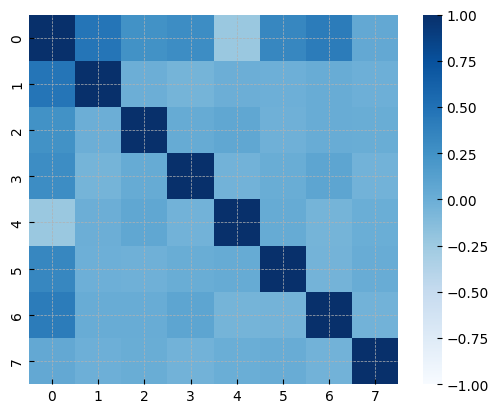

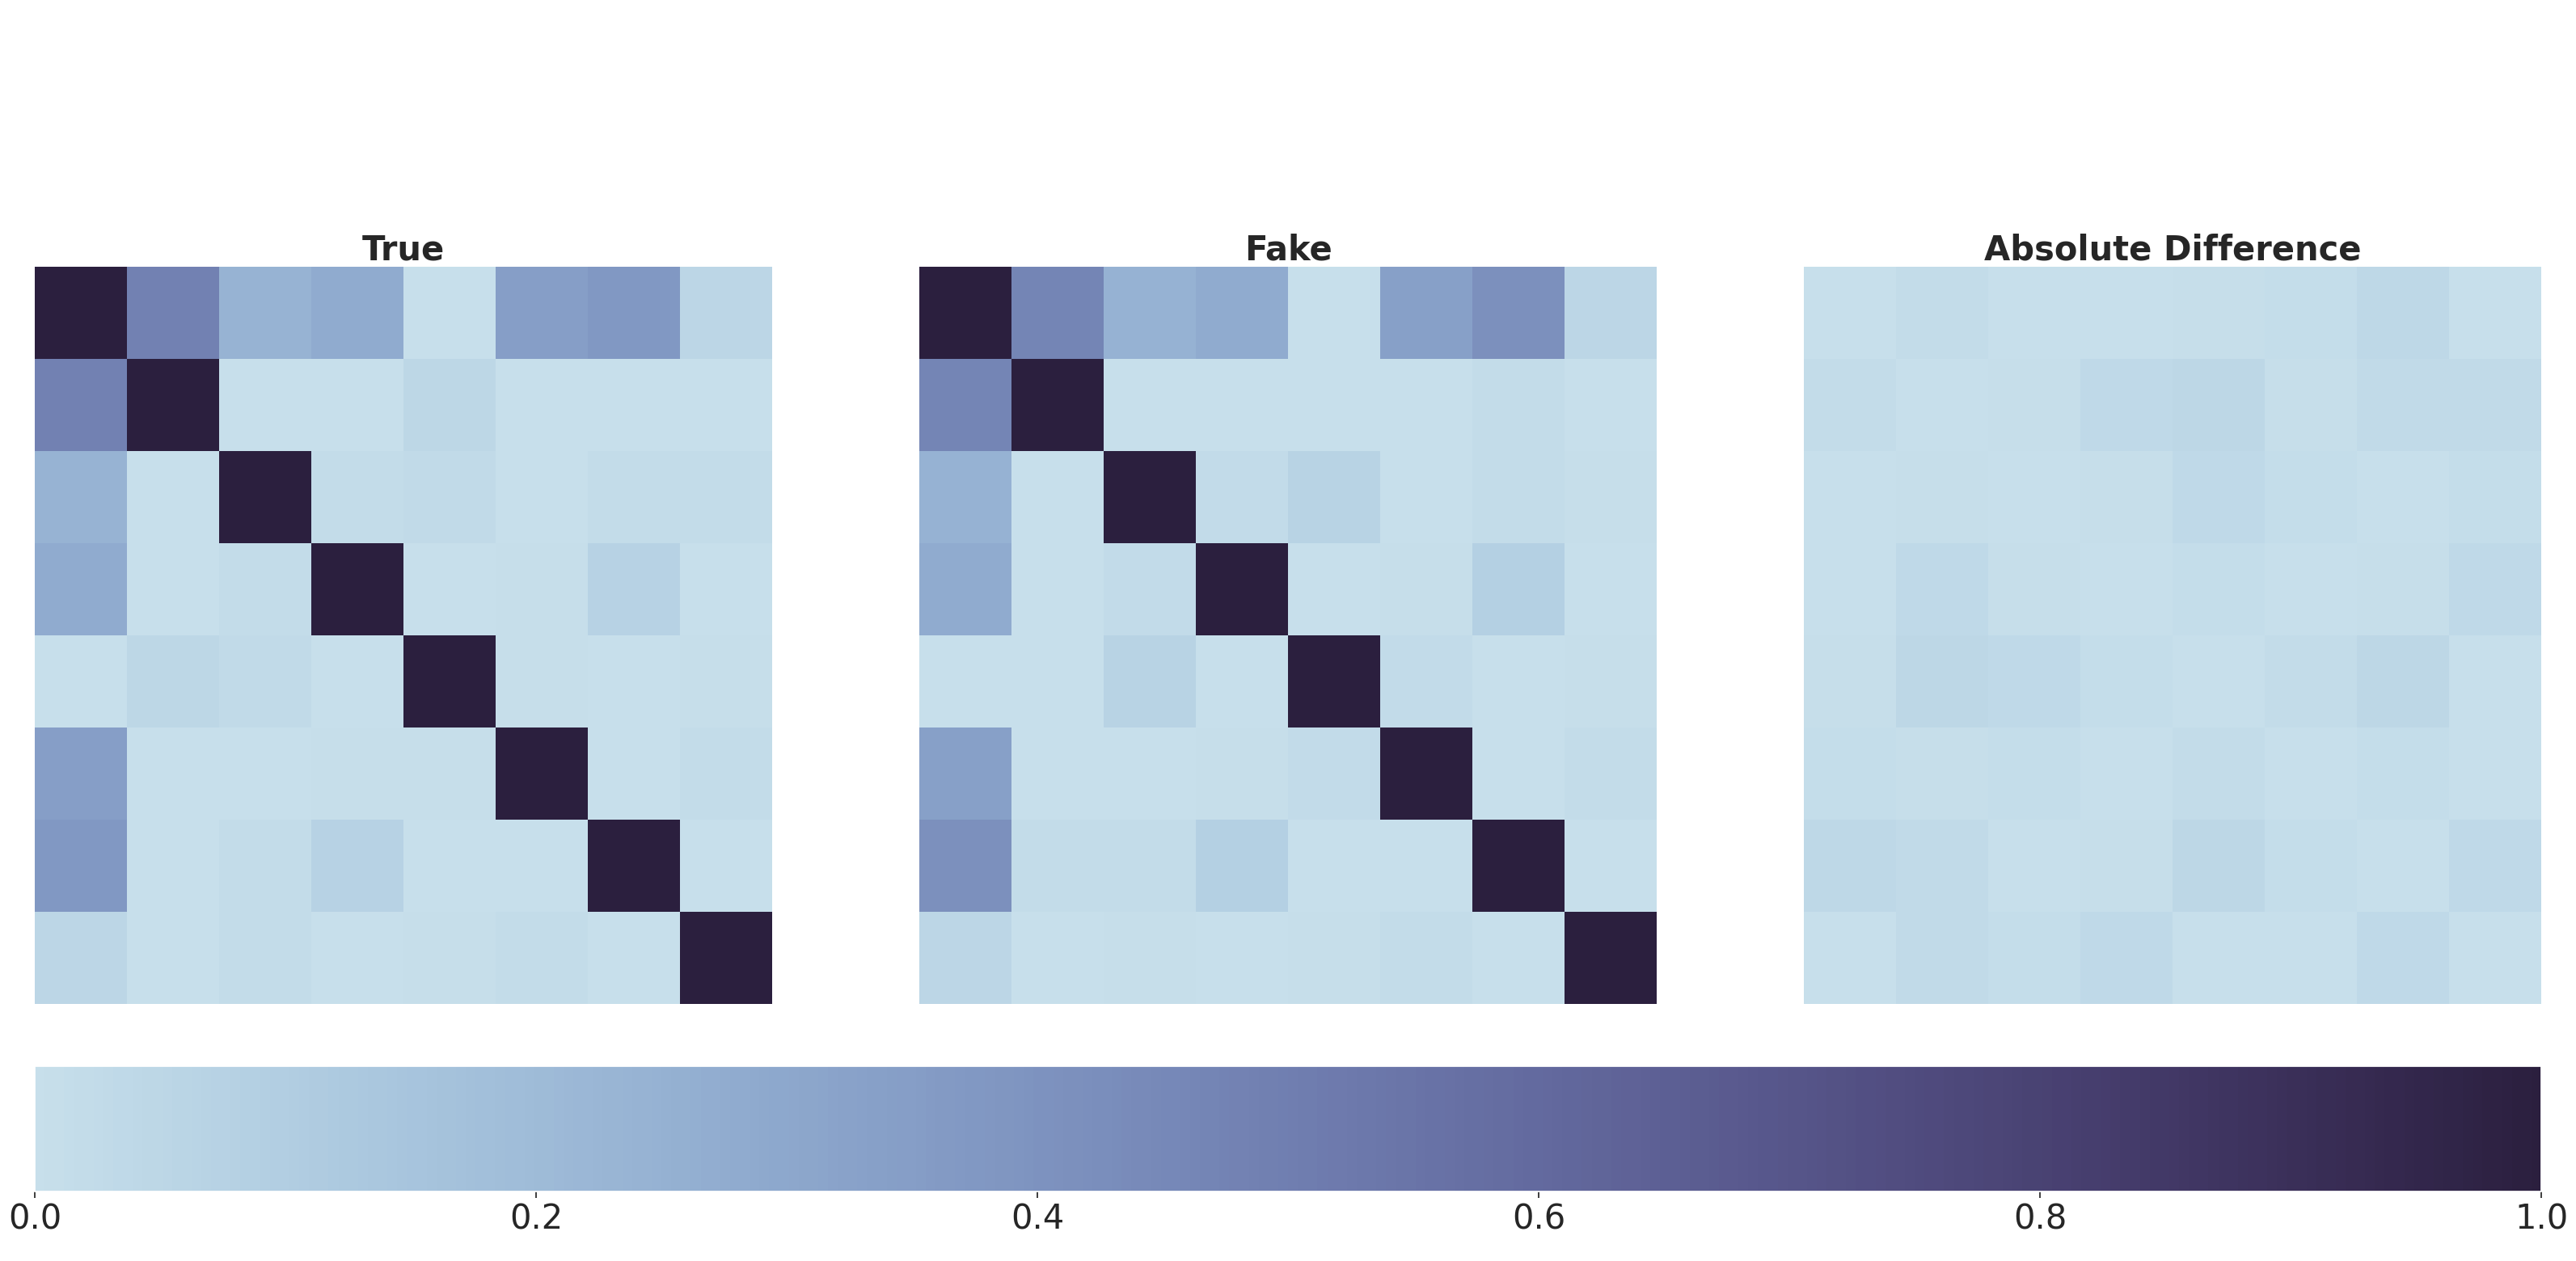

In [167]:
heatmap_correlation(df_true, df_fake, "True", "Fake")

## Conditional generation via missing value imputation technique

* RePaint: https://arxiv.org/pdf/2201.09865.pdf
* TabSyn: https://arxiv.org/pdf/2310.09656v1.pdf

In [168]:
# Masking the response column
yx_mask = np.ones(yx_true_unnorm.shape)
yx_mask[:, 0] = 0

# Conditional generation
yx_true_norm = torch.tensor(yx_true_norm, dtype=torch.float32)
yx_mask = torch.tensor(yx_mask, dtype=torch.float32)
yx_fake_pred = generate_imputation(
    tabular_ddpm, yx_true_norm, yx_mask, resampling_steps=10
)

Imputation at step 993:   1%|          | 7/1000 [00:00<00:16, 62.03it/s]

### Distributional evaluation on training set

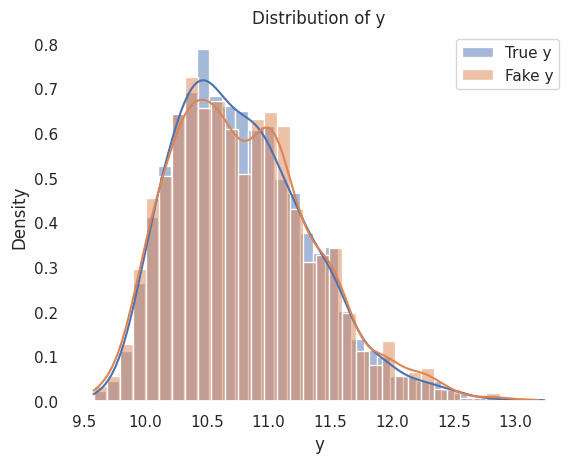

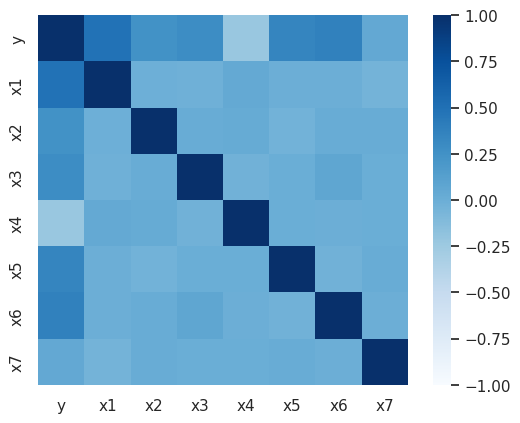

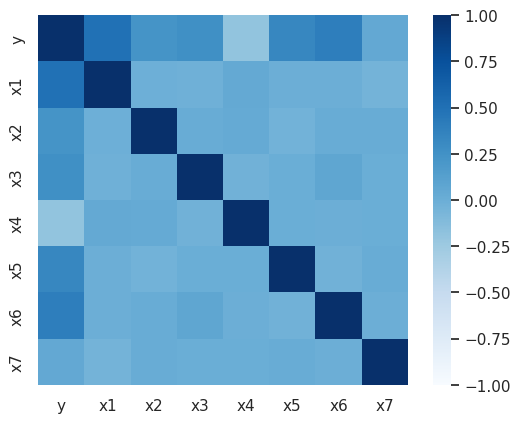

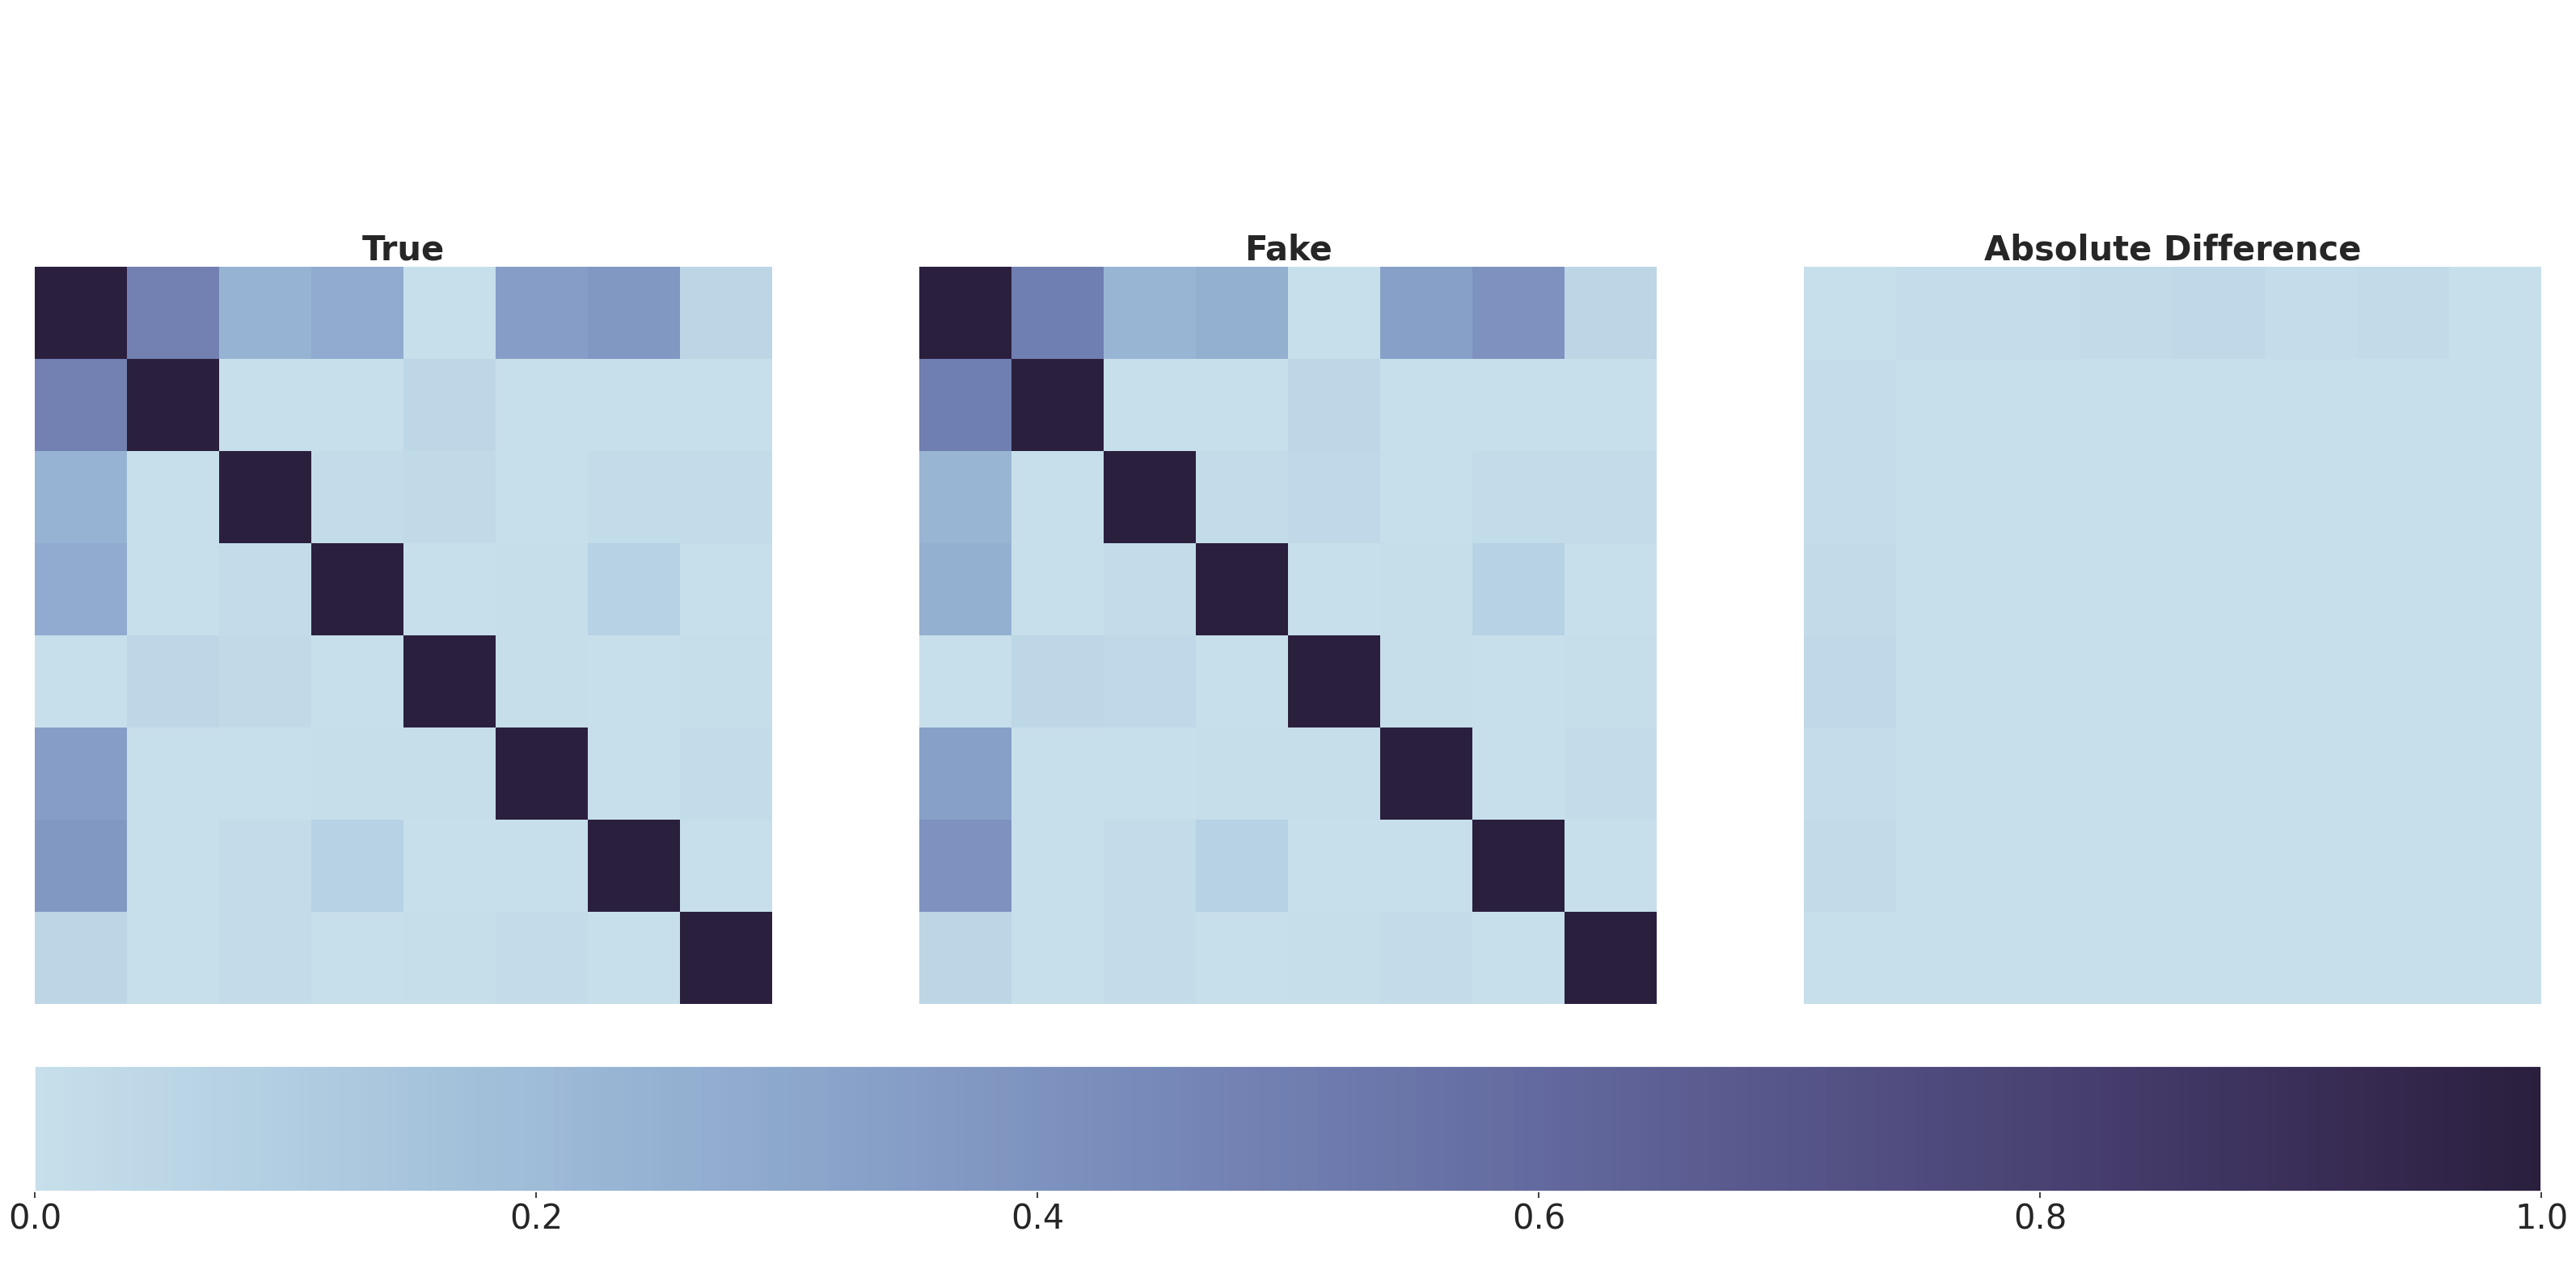

In [169]:
yx_fake_pred_unnorm = qt.inverse_transform(yx_fake_pred.cpu().detach().numpy())
df_true, df_fake = pd.DataFrame(yx_true_unnorm), pd.DataFrame(yx_fake_pred_unnorm)
df_true.columns = df_fake.columns = ["y", "x1", "x2", "x3", "x4", "x5", "x6", "x7"]

plot_distribution([df_true, df_fake], "y", ["True", "Fake"])
# compare_distributions_grid([df_true, df_fake], ["True", "Fake"], nrows=3, ncols=3)
heatmap_correlation(df_true, df_fake, "True", "Fake")

### Supervised evaluation on independent test set

I found the generation speed is the same for n_samples = 200 versus n_samples = 5000

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Generate test data #
n_test = 200
true_sampler = TrueSampler(sigma=0.2)
X, y, mean_y, sigma_x = true_sampler.sample(n_test, return_mean=True) # return E(y|X) as well
yx_test = np.concatenate([y[:, None], X], axis=1)

np.save("./data/yx_test.npy", yx_test)
np.save("./data/mean_y_test.npy", mean_y)
np.save("./data/sigma_x_test.npy", sigma_x)



# Quantile transformation #
qt = QuantileTransformer(output_distribution="normal", random_state=seed)
qt.fit(yx_test)
yx_norm = qt.transform(yx_test)
yx_norm = torch.tensor(yx_norm, dtype=torch.float32)

joblib.dump(qt, "./ckpt/qt_test.joblib")


# Get the test data and the corresponding quantile transformer #
yx_unnorm = np.load("./data/yx_test.npy")
qt = joblib.load("./ckpt/qt_test.joblib")
yx_norm = qt.transform(yx_unnorm)


X shape:  (200, 7)
y shape:  (200,)


/home/liu00980/.conda/envs/tddpm/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
# Conditional generation for predicting y #
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


n_test = yx_norm.shape[0]
D = 1000  # Monte Carlo size
D_batch = 100  # non-linear growth, so split into batches

batch_sizes = [D_batch] * (D // D_batch) + ([D % D_batch] if D % D_batch != 0 else [])

y_dict = {
    "y_true": yx_unnorm[:, 0],
    "y_pred_list": [],
}

for i, batch_size in enumerate(batch_sizes):
    print(f"Processing batch {i} with batch size {batch_size}...")

    # stacking all together for fast processing
    input_norm = np.vstack([yx_norm] * batch_size)

    input_norm = torch.tensor(input_norm, dtype=torch.float32)
    input_mask = torch.ones(input_norm.shape, dtype=torch.float32)
    input_mask[:, 0] = 0

    output_norm = generate_imputation(
        tabular_ddpm, input_norm, input_mask, resampling_steps=10
    )
    output_unnorm = qt.inverse_transform(output_norm.cpu().detach().numpy())

    # save the result
    y_dict["y_pred_list"].extend(
        [temp[:, 0] for temp in np.split(output_unnorm, batch_size, axis=0)]
    )
    pickle.dump(y_dict, open(f"./result/y_pred_dict.pkl", "wb"))

In [7]:
y_dict = pickle.load(open("./result/y_pred_dict.pkl", "rb"))

y_true = y_dict["y_true"]
y_pred_list = y_dict["y_pred_list"]

y_true.shape

(200,)

In [8]:
# Evaluation #

y_dict = pickle.load(open("./result/y_pred_dict.pkl", "rb"))

mean_y = np.load("./data/mean_y_test.npy")
sigma_x = np.load("./data/sigma_x_test.npy")
y_true = y_dict["y_true"]
y_pred_list = y_dict["y_pred_list"]
y_pred_array = np.stack(y_pred_list, axis=0)  # (D, n_test)

# RMSE
y_pred_synthetic = y_pred_array.mean(axis=0)
rmse = np.sqrt(np.mean((y_true - y_pred_synthetic) ** 2))
print("RMSE:", rmse)

RMSE: 0.3033752041658048


In [9]:
# Calculation of CI#
alpha = 0.05

n_samples = len(mean_y)

ci_true_l_list = norm.ppf(alpha / 2, loc=mean_y, scale=sigma_x)
ci_true_u_list = norm.ppf(1 - alpha / 2, loc=mean_y, scale=sigma_x)

alpha_soft = alpha
ci_fake_l_list = np.percentile(y_pred_array, alpha_soft / 2 * 100, axis=0)
ci_fake_u_list = np.percentile(y_pred_array, (1 - alpha_soft / 2) * 100, axis=0)


### Conformal prediction interval

In [10]:
yx_train_unnorm = np.load("./data/yx.npy")
yx_test_unnorm = np.load("./data/yx_test.npy")

columns_names = ["y", "x1", "x2", "x3", "x4", "x5", "x6", "x7"]
df_train = pd.DataFrame(yx_train_unnorm)
df_test = pd.DataFrame(yx_test_unnorm)
df_train.columns = df_test.columns = columns_names

n, n_test = len(yx_train_unnorm), len(yx_test_unnorm)
r_model, r_val, r_calib = 0.6, 0.2, 0.2
n_model, n_val = int(n * r_model), int(n * r_val)
n_calib = n - n_model - n_val # calibration size

df_model = df_train.iloc[:n_model, :]
df_val = df_train.iloc[n_model : n_model + n_val, :]
df_calib = df_train.iloc[n_model + n_val :, :]


# train predictive model with early stopping
model_fit = catboost_pred_model(df_model, df_val, num_features_list=columns_names[1:])


no null features, using all specified features for training
Learning rate set to 0.055844
0:	learn: 0.5374550	test: 0.5342852	best: 0.5342852 (0)	total: 49.8ms	remaining: 49.7s
1:	learn: 0.5230284	test: 0.5215417	best: 0.5215417 (1)	total: 52.1ms	remaining: 26s
2:	learn: 0.5083539	test: 0.5079831	best: 0.5079831 (2)	total: 54.4ms	remaining: 18.1s
3:	learn: 0.4946190	test: 0.4957841	best: 0.4957841 (3)	total: 56.2ms	remaining: 14s
4:	learn: 0.4820583	test: 0.4842689	best: 0.4842689 (4)	total: 57.5ms	remaining: 11.4s
5:	learn: 0.4705740	test: 0.4741892	best: 0.4741892 (5)	total: 58.9ms	remaining: 9.76s
6:	learn: 0.4589081	test: 0.4632721	best: 0.4632721 (6)	total: 60.4ms	remaining: 8.57s
7:	learn: 0.4481974	test: 0.4534294	best: 0.4534294 (7)	total: 61.8ms	remaining: 7.66s
8:	learn: 0.4381465	test: 0.4446595	best: 0.4446595 (8)	total: 63.1ms	remaining: 6.94s
9:	learn: 0.4286546	test: 0.4357025	best: 0.4357025 (9)	total: 64.4ms	remaining: 6.38s
10:	learn: 0.4187576	test: 0.4265884	best: 0

In [11]:
# get conformal scores

y_calib, y_pred_calib, rmse = test_rmse(
    model_fit, df_calib, columns_names[1:], return_individual=True
)
conformal_scores = np.abs(y_calib - y_pred_calib) / rmse


# get predictive intervals on test set
alpha = 0.05
q_cs = np.quantile(conformal_scores, 1 - alpha)

_, y_pred_test, _ = test_rmse(
    model_fit, df_test, columns_names[1:], return_individual=True
)

ci_conformal_l_list = y_pred_test - q_cs * rmse
ci_conformal_u_list = y_pred_test + q_cs * rmse

### Comparison

#### 95% prediction interval

Text(0.5, 1.0, '95.0% PI for E(y|X)')

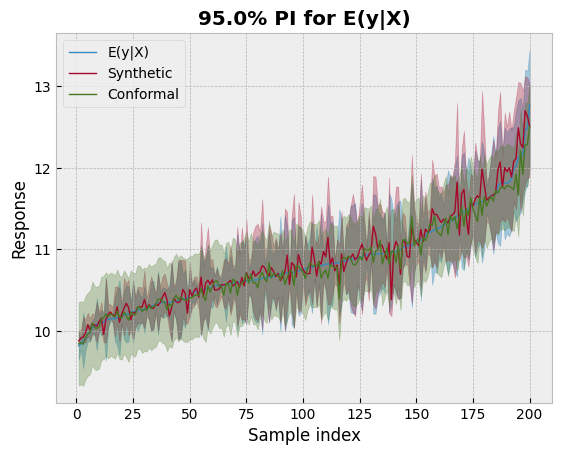

In [12]:
def get_increasing_indices(arr: np.array):
    "Get index array I such that arr[I] is increasing."
    n = len(arr)

    numbers = np.arange(n, dtype=int)
    temp = sorted(numbers, key=lambda i: arr[i])
    return numbers[np.array(temp)]


plt.style.use("bmh")

x_indices = np.arange(1, len(mean_y) + 1)
I_true = get_increasing_indices(mean_y)

# underlying truth
plt.plot(x_indices, mean_y[I_true], "-", label="E(y|X)", lw=1, color="C0")
plt.fill_between(
    x_indices,
    ci_true_l_list[I_true],
    ci_true_u_list[I_true],
    alpha=0.4,
    color="C0",
)

# using synthetic data
plt.plot(x_indices, y_pred_synthetic[I_true], "-", label="Synthetic", lw=1, color="C1")
plt.fill_between(
    x_indices,
    ci_fake_l_list[I_true],
    ci_fake_u_list[I_true],
    alpha=0.3,
    color="C1",
    
)


# using conformal inference
plt.plot(x_indices, y_pred_test[I_true], "-", label="Conformal", lw=1, color="C3")
plt.fill_between(
    x_indices,
    ci_conformal_l_list[I_true],
    ci_conformal_u_list[I_true],
    alpha=0.3,
    color="C3",
)


plt.legend()

plt.xlabel("Sample index")
plt.ylabel("Response")
plt.title(f"{(1-alpha) * 100}% PI for E(y|X)", weight="bold")

Text(0.5, 1.0, '95.0% prediction interval for y|X')

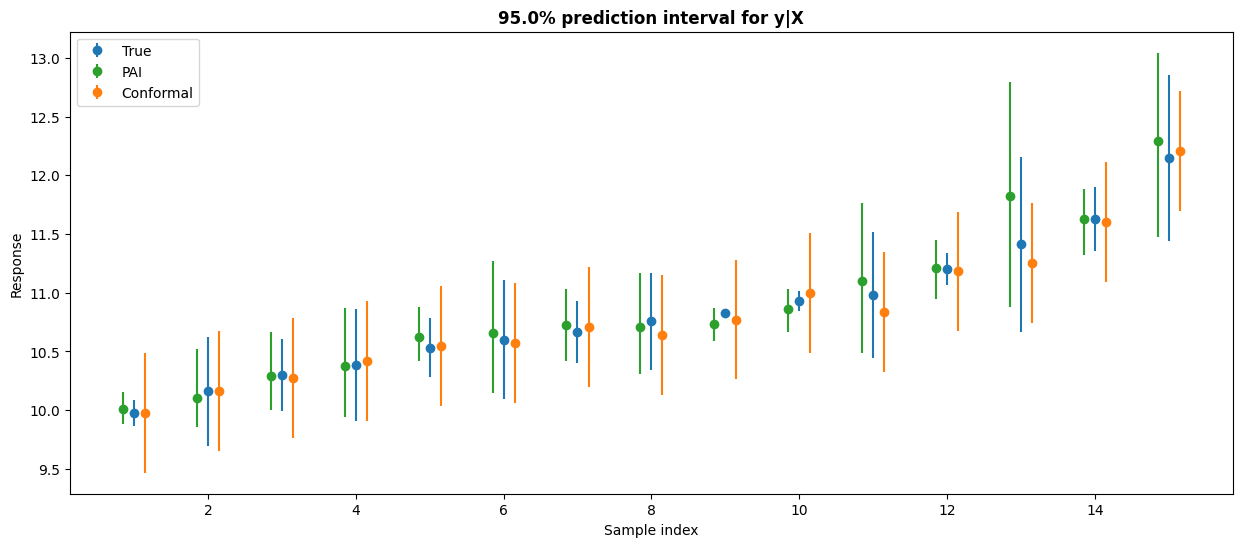

In [54]:
n_viz = 15

I = get_increasing_indices(mean_y)
idx_viz = I[np.linspace(5, 195, n_viz, dtype=int)]

# np.random.seed(seed)
# idx_viz = np.random.choice(n_test, n_viz, replace=False)

x_indices = np.arange(1, n_viz + 1)

plt.style.use("default")
plt.figure(figsize=(15, 6))

# true E(y|X)
# plt.scatter(
#     x_indices,
#     mean_y[idx_viz],
#     marker="x",
#     color="C0",
#     label="E(y|X)",
# )
plt.errorbar(
    x_indices,
    mean_y[idx_viz],
    yerr=[mean_y[idx_viz] - ci_true_l_list[idx_viz], ci_true_u_list[idx_viz] - mean_y[idx_viz]],
    fmt="o",
    label="True",
    color="C0",
)

# synthetic
plt.errorbar(
    x_indices - 0.15,
    y_pred_synthetic[idx_viz],
    yerr=[
        y_pred_synthetic[idx_viz] - ci_fake_l_list[idx_viz],
        ci_fake_u_list[idx_viz] - y_pred_synthetic[idx_viz],
    ],
    fmt="o",
    label="PAI",
    color="C2",
)

# conformal
plt.errorbar(
    x_indices + 0.15,
    y_pred_test[idx_viz],
    yerr=[
        y_pred_test[idx_viz] - ci_conformal_l_list[idx_viz],
        ci_conformal_u_list[idx_viz] - y_pred_test[idx_viz],
    ],
    fmt="o",
    label="Conformal",
    color="C1",
)

plt.legend(loc="upper left")

plt.xlabel("Sample index")
plt.ylabel("Response")
plt.title(f"{(1-alpha) * 100}% prediction interval for y|X", weight="bold")

In [14]:
np.mean(
    ((ci_conformal_u_list - ci_conformal_l_list) - (ci_true_u_list - ci_true_l_list))
    > 0
)

0.68

In [15]:
np.mean(
    ((ci_conformal_u_list - ci_conformal_l_list) - (ci_fake_u_list - ci_fake_l_list))
    > 0
)

0.685

#### Coverage probabilities

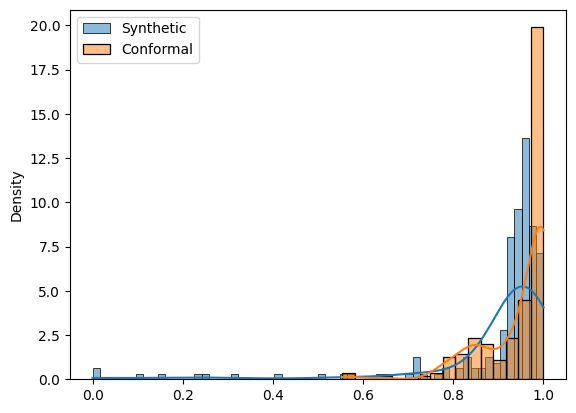

In [16]:
def get_coverage_probs(mean_list, std_list, ci_l_list, ci_u_list):
    "Get the coverage probabilities for the given intervals based on gaussians"
    n = len(mean_list)

    prob_list = []
    for i in range(n):
        p1 = norm.cdf(ci_l_list[i], loc=mean_list[i], scale=std_list[i])
        p2 = norm.cdf(ci_u_list[i], loc=mean_list[i], scale=std_list[i])
        prob_list.append(p2 - p1)

    return np.array(prob_list)


probs_synthetic = get_coverage_probs(
    mean_y, sigma_x, ci_fake_l_list, ci_fake_u_list
)
probs_conformal = get_coverage_probs(
    mean_y, sigma_x, ci_conformal_l_list, ci_conformal_u_list
)

sns_kargs = {
    "kde": True,
    "stat": "density",
    "multiple": "dodge",
}


sns.histplot(probs_synthetic, label="Synthetic", color="C0", **sns_kargs)
sns.histplot(probs_conformal, label="Conformal", color="C1", **sns_kargs)

plt.legend()

In [17]:
print("Mean:", probs_synthetic.mean(), probs_conformal.mean())
print("Median:", np.median(probs_synthetic), np.median(probs_conformal))

Mean: 0.8981399632827697 0.9443798058092182
Median: 0.9495280920046665 0.988048030919639


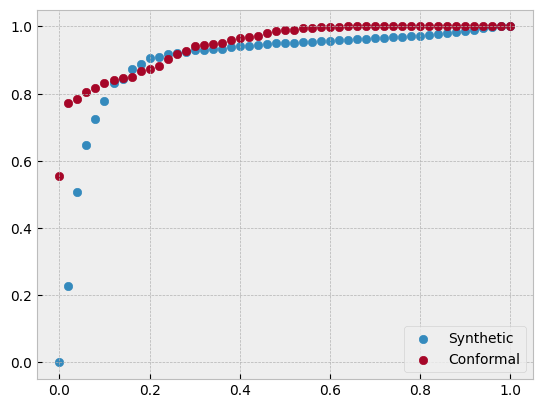

In [18]:
# plot the quantiles of the coberage probabilities

probs = np.linspace(0, 1, 51)

qs_synthetic = np.quantile(probs_synthetic, probs)
qs_conformal = np.quantile(probs_conformal, probs)


plt.style.use("bmh")
plt.scatter(probs, qs_synthetic, label="Synthetic", color="C0")
plt.scatter(probs, qs_conformal, label="Conformal", color="C1")

plt.legend()


Text(0.5, 1.0, 'Distribution of coverage probabilities ($\\alpha=0.05$)')

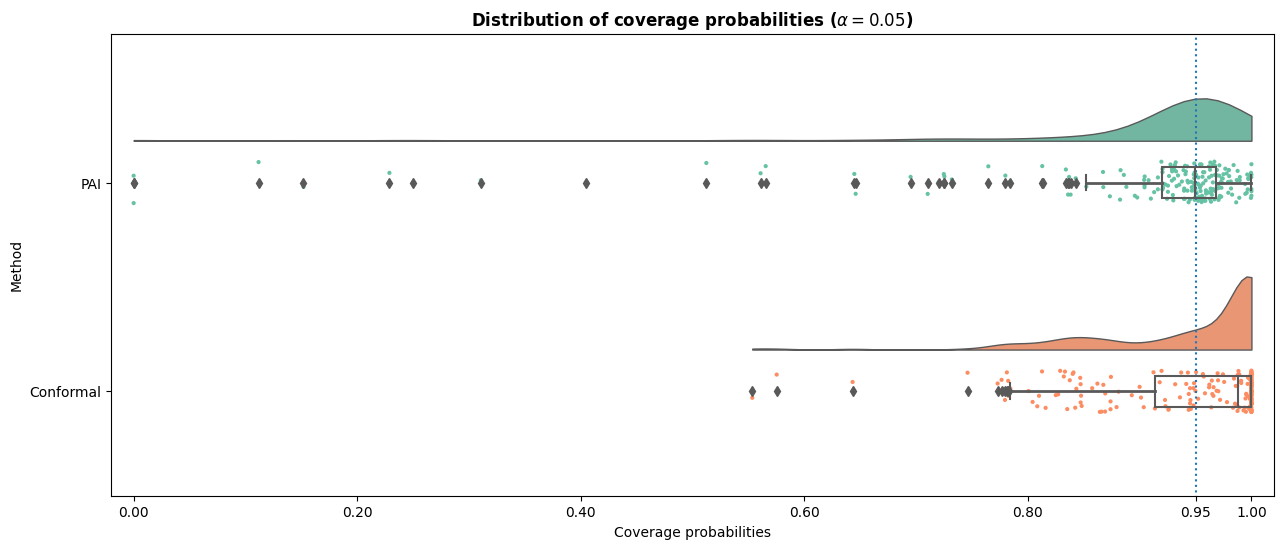

In [52]:
temp_df = pd.DataFrame(
    {
        "Coverage probabilities": np.concatenate([probs_synthetic, probs_conformal]),
        "Method": ["PAI"] * n_test + ["Conformal"] * n_test,
    }
)


plt.figure(figsize=(15, 6))
pt.RainCloud(x="Method", y="Coverage probabilities", data=temp_df, orient="h")
plt.vlines(0.95, -1, 2, color="C0", linestyles="dotted")

plt.xticks(list(plt.xticks()[0]) + [0.95])
plt.xlim(-0.02, 1.02)

plt.title(r"Distribution of coverage probabilities ($\alpha=0.05$)", weight="bold")


Text(0.5, 1.0, '95.0% prediction interval')

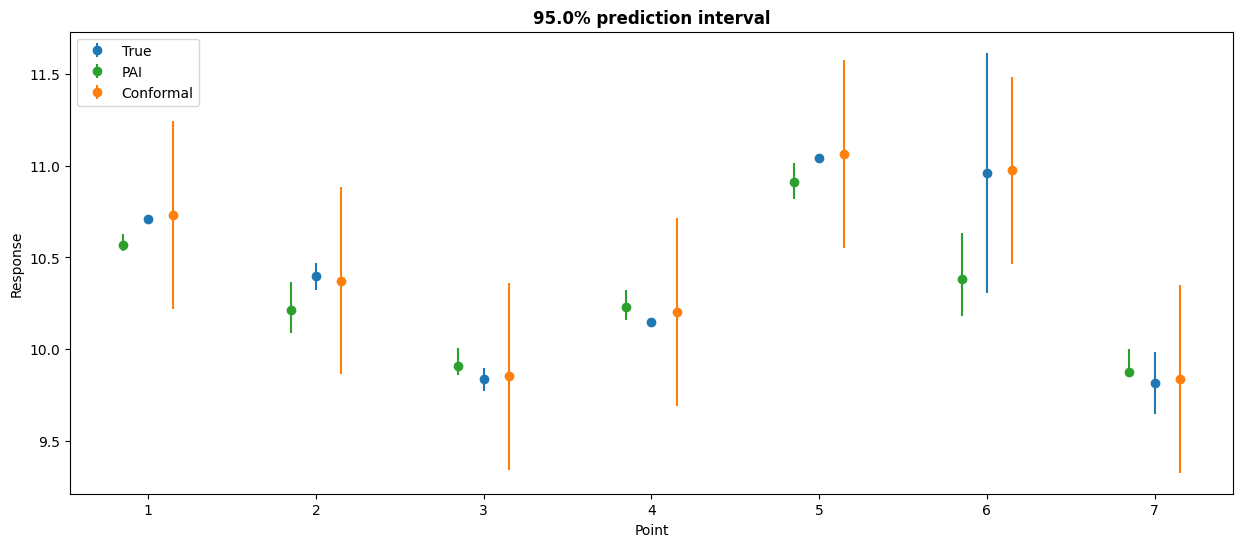

In [55]:
weird_points_idx = np.arange(0, len(probs_synthetic))[probs_synthetic <= 0.4]



# replicate from a previous cell #

n_viz = len(weird_points_idx)
idx_viz = weird_points_idx

# np.random.seed(seed)
# idx_viz = np.random.choice(n_test, n_viz, replace=False)

x_indices = np.arange(1, n_viz + 1)

plt.style.use("default")
plt.figure(figsize=(15, 6))

# true E(y|X)
# plt.scatter(
#     x_indices,
#     mean_y[idx_viz],
#     marker="x",
#     color="C0",
#     label="E(y|X)",
# )
plt.errorbar(
    x_indices,
    mean_y[idx_viz],
    yerr=[mean_y[idx_viz] - ci_true_l_list[idx_viz], ci_true_u_list[idx_viz] - mean_y[idx_viz]],
    fmt="o",
    label="True",
    color="C0",
)

# synthetic
plt.errorbar(
    x_indices - 0.15,
    y_pred_synthetic[idx_viz],
    yerr=[
        y_pred_synthetic[idx_viz] - ci_fake_l_list[idx_viz],
        ci_fake_u_list[idx_viz] - y_pred_synthetic[idx_viz],
    ],
    fmt="o",
    label="PAI",
    color="C2",
)

# conformal
plt.errorbar(
    x_indices + 0.15,
    y_pred_test[idx_viz],
    yerr=[
        y_pred_test[idx_viz] - ci_conformal_l_list[idx_viz],
        ci_conformal_u_list[idx_viz] - y_pred_test[idx_viz],
    ],
    fmt="o",
    label="Conformal",
    color="C1",
)

plt.legend(loc="upper left")

plt.xlabel("Point")
plt.ylabel("Response")
plt.title(f"{(1-alpha) * 100}% prediction interval", weight="bold")


Comparison is not fair:
- Conditional generation versus conditional generation in conformal inference
- Tune generator for better performance